Ovaj primer ilustruje primenu diskretne Furijeove transformacije u radu radara. Radari su uredjaji koji emituju radio talase i obradjuju njihove refleksija u cilju ispitivanja okoline. Mogu se susresti u avijaciji, meteorologiji, geologiji i mnogim drugim oblastima. Prikaz osnovnih komponenti radara je dat na slici.
<br> 
Radar koji se nadalje razmatra spada u grupu linearno modulisanih FMCW (Frequency-Modulated Continuous-Wave) radara cije frekvencije emitovanja variraju u vremenu.
<br>
    <img src='radar_flow.png'> 

Ukoliko se dva signala cije su frekvencije redom $x$ i $y$ pomnoze, na osnovu adicionih formula vazi $ \sin(xt) \sin(yt) = \frac{1}{2} \left[ \sin \left( (x - y)t + \frac{\pi}{2} \right) - \sin \left( (x + y)t + \frac{\pi}{2} \right) \right] $. Ako se rezultujuci signal dalje propusti kroz niskopropusni filter faktor $\sin((x + y)t + \frac{\pi}{2})$ ce se eliminisati pa ce ostati samo faktor $\sin( (x - y)t + \frac{\pi}{2})$ koji ukazuje da se na osnovu razlika u frekvencijama emitovanog i primljenog signala moze zakljucivati o udaljenosti objekata. 

In [2]:
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# parametri radara 

# frekvencija uzorkovanja u hercima
fs = 78125          

# vreme uzorkovanja - na svakih ts sekundi se meri vrednost signala
ts = 1.0 / fs         

# broj uzoraka 
N = 2048

# ukupno vreme uzorkovanja signala u sekundama (eng. akka effective sweep duration)
Teff = N * ts  
                    
# opseg frekvencija signala koji se postize za ukupno vreme uzorkovanja signala (eng. effective bandwidth)
Beff = 100e6         
                            
# velicina promene frekvencije u jedinici vremena (eng. frequency sweep rate) u Hz/s        
S = Beff / Teff 

# brzina radio talasa priblizno odgovara brzini svetlosti
c = 3e8  

Ideja zadatka je da se isprati ponasanje radara tj. njegovog frekvencijskog spektra ukoliko su poznata rastojanja
i velicine objekata koje detektuje.
U praksi je pristup problemu inverzan - na osnovu frekvencijskih spektara radara se odredjuju udaljenosti objekata i njihove dimenzije.
<br> 
Ovde je cilj da se uverimo da ovakav model zaista ima smisla. 

In [4]:
# specifikacija ciljnih objekata 

# rastojanja objekata (u metrima)
R = np.array([100, 137, 154, 159,  180])  

# velicine objekata 
M = np.array([0.33, 0.2, 0.9, 0.02, 0.1])  

# slucajno odabrane faze signala duz kojih su objekti detektovani
P = np.array([0, np.pi / 2, np.pi / 3, np.pi / 5, np.pi / 6])  

In [5]:
# vremena uzorkovanja signala
t = np.arange(N) * ts 

# frekvencijske razlike 
# ako je signal putovao tx sekundi, frekvencija radara se u medjuvremenu promenila za tx*S
# tx odgovara vremenu signala potrebno da od radara stigne do objekta i 
# vrati se nazad pa je formula po kojoj se vreme tx moze izracunati predjeni_put/brzina = 2*R/c
# time se frekvencijska razlika radara moze izraziti sa
fd = 2 * S * R / c      

# signali koji odgovaraju detektovanim objektima 
# pokrivaju se istovremeno oblici svih detektovanih signala 
# signal0 = np.cos(2 * pi * fd[0] * t)
# signal1 = np.cos(2 * pi * fd[1] * t + pi / 2)
# signal2 = np.cos(2 * pi * fd[2] * t + pi / 3)
# signal3 = np.cos(2 * pi * fd[3] * t + pi / 5)
# signal4 = np.cos(2 * pi * fd[4] * t + pi / 6)

signals = np.cos(2 * np.pi * fd * t.reshape(N, 1) + P)

# kombinovani signal koji radar prima odgovara sumi reflektovanih signala pomnozenih velicinama objekata
# v_sim = (0.33 * signal0) + (0.2 * signal1) + (0.9 * signal2) + (0.02 * signal3) + (0.1 * signal4)
v_sim = np.sum(M * signals, axis=1)

In [6]:
# odredjujemo Furijeovu transformaciju signala   
V_sim = np.fft.fft(v_sim)

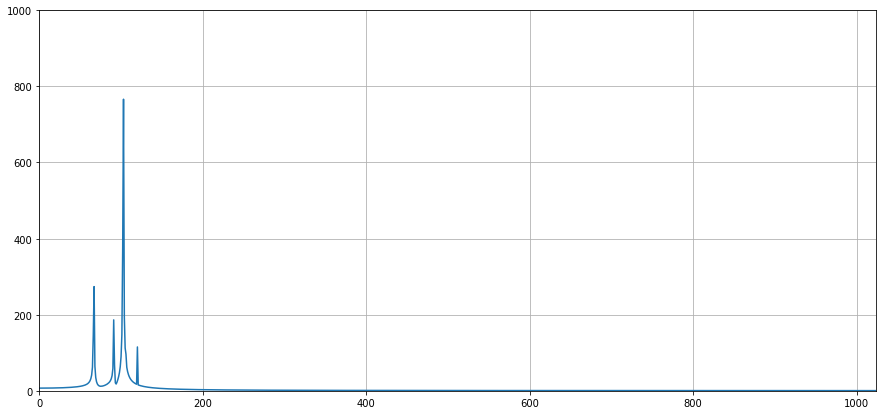

In [26]:
# iscrtavamo frekvencijski spektar (sampo pozitivne delove)
# figure, axes = plt.subplots(1, 1, figsize=(15, 7))

# axes.plot(np.abs(V_sim[:N // 2]))
# axes.set_xlim(0, N // 2)
# axes.set_ylabel("V_sim")
# axes.set_ylim(0, 1000)

# axes.grid()

# plt.show()

plt.figure(figsize=(15, 7))
plt.xlim(0, N//2)
plt.ylim(0, 1000)
plt.grid()
plt.plot(np.abs(V_sim[:N//2]))

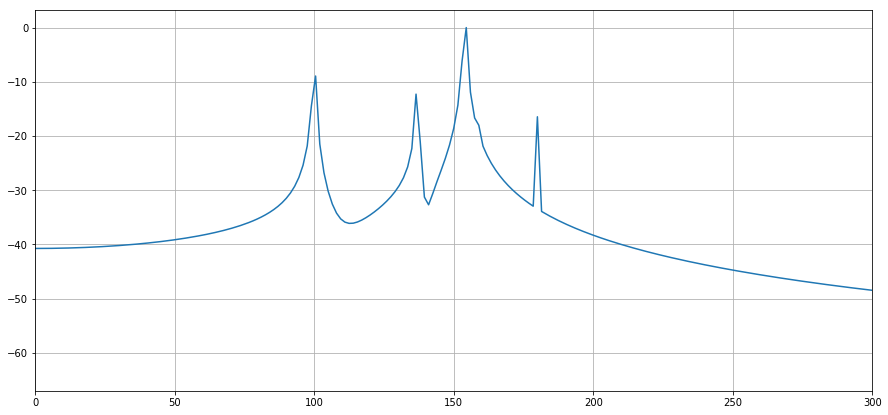

In [35]:
def dB(power):
    "Funkcija izracunava log kolicnik power/ max(power) u decibelima."

    power = np.abs(power)
    power /= power.max()

    return 20 * np.log10(power)

plt.figure(figsize=(15, 7))
plt.grid()
plt.xlim(0, 300)

range = np.arange(N // 2) * c / (2 * Beff)

plt.plot(range, dB(V_sim[:N // 2]))


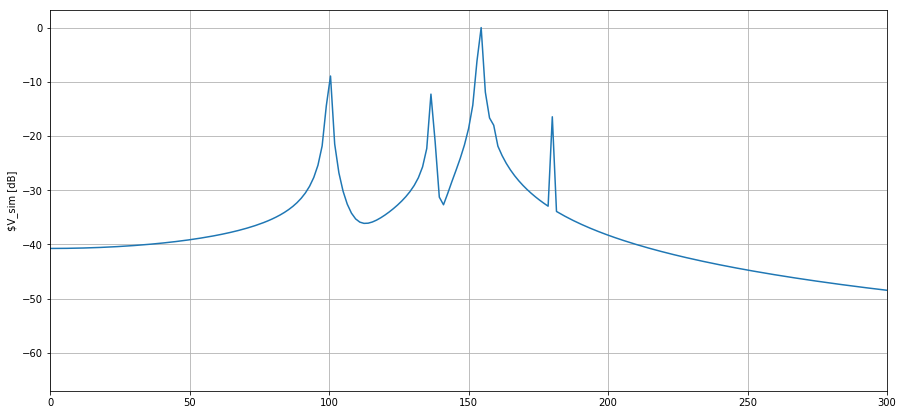

In [8]:
# iscrtavamo frekvencijske spektre signala ali na nesto preciznijoj skali i u decibelima 
figure, axis = plt.subplots(1, 1, figsize=(15, 7))

# vrednosti signala se obicno izrazavaju u decibelima
def dB(power):
    "Funkcija izracunava log kolicnik power/ max(power) u decibelima."

    power = np.abs(power)
    power /= power.max()

    return 20 * np.log10(power)


def log_plot_normalized(x, y, ylabel, ax):
    "Funkcija iscrtava zadate vrednosti u decibelima"
    ax.plot(x, dB(y))
    ax.set_ylabel(ylabel)
    ax.grid()


# moguce vrednosti frekvencija signala (eng. range bins)
range = np.arange(N // 2) * c / 2 / Beff

# iscrtavamo frekvencijske spektre signala
log_plot_normalized(range, V_sim[:N // 2], "$V_sim [dB]", axis)

# menjamo skale na frekvencijskoj osi da bi preciznije mogli da vidimo pikove
axis.set_xlim(0, 300)  


plt.show()

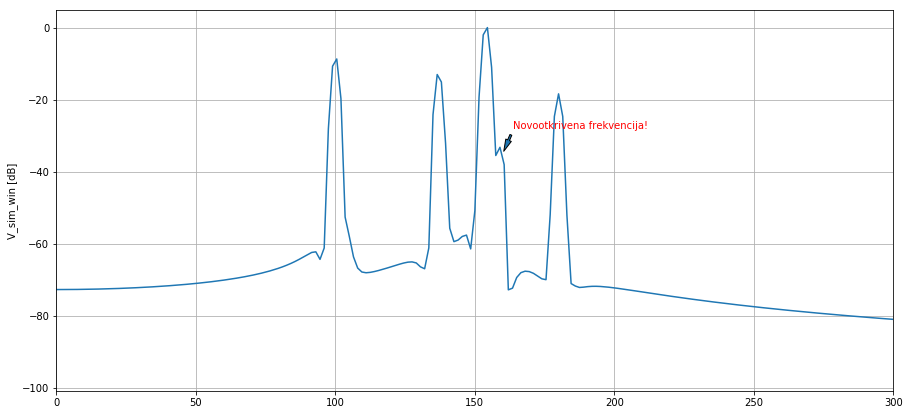

In [9]:
# sa slike mozemo da zakljucimo da frekvencije zaista odgovaraju udaljenostima objekata
# jedna frekvencija ipak nije prepoznata jer radar ima poteskocu da razlikuje bliske frekvencije (154 i 159 u ovom slucaju)
# zbog toga cemo koristiti prozorsku funkciju, npr. Kasierov prozor sa paremtrom beta = 6.1 
w = np.kaiser(N, 6.1) 

V_sim_win = np.fft.fft(w * v_sim)

# iscrtavamo novi frekvencijski spektar signala 
figure, axis = plt.subplots(1, 1, figsize=(15, 7))
range = np.arange(N // 2) * c / 2 / Beff
log_plot_normalized(range, V_sim_win[:N // 2], "V_sim_win [dB]", axis)
axis.set_xlim(0, 300)  

axis.annotate("Novootkrivena frekvencija!", (160, -35),
             xytext=(10, 25), textcoords="offset points", color='red',
             arrowprops=dict(width=2, headwidth=6, headlength=12, shrink=0.1))

plt.show()

## Za pročitati: 
    * http://www.radartutorial.eu/
    * https://en.wikipedia.org/wiki/Radar